In [11]:
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

result_dataset_path = Path("/app/datasets/interpolation")
result_dataset_path.mkdir(exist_ok=True)
loose_crop_path = result_dataset_path / "loose_crop"
loose_crop_path.mkdir(exist_ok=True)

In [2]:
raw_image_path = "/app/datasets/interpolation.png"
raw_image = cv2.imread(raw_image_path)

In [9]:
id_to_images = {id: [] for id in range(3)}
for i in range(3):
    out_path = result_dataset_path / str(i)
    out_path.mkdir(exist_ok=True)
    for j in range(9):
        crop_image = raw_image[i * 256 : (i + 1) * 256, j * 256 : (j + 1) * 256]
        id_to_images[i].append(crop_image)
        cv2.imwrite(str(out_path / (str(j).zfill(4) + ".jpg")), crop_image)
        cv2.imwrite(
            str(loose_crop_path / (str(i) + "_" + str(j).zfill(4) + ".jpg")), crop_image
        )

### Get embeddings

In [4]:
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

app = FaceAnalysis(
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
    root="./data/insightface",
)
app.prepare(ctx_id=0, det_size=(256, 256))

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./data/insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./data/insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./data/insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./data/insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./data/insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (256, 256)


In [15]:
id_to_landmarks = {id: [] for id in range(3)}
for id in id_to_images:
    out_path = result_dataset_path / str(id)
    for j in range(9):
        # image_path = str(out_path / (str(j).zfill(4)+'.jpg'))
        # image = cv2.imread(image_path)[:,:,::-1]
        image = id_to_images[id][j]
        faces = app.get(image)
        assert len(faces) == 1, j
        id_to_landmarks[id].append(faces[0]["kps"])

/home/erlygin/miniconda/lib/python3.9/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [14]:
# save landmarks
meta_dir = result_dataset_path / "meta"
meta_dir.mkdir(exist_ok=True)
with open(meta_dir / "inter_name_5pts_score.txt", "w") as fd:
    for id in id_to_landmarks:
        for j in range(9):
            name = str(id) + "_" + str(j).zfill(4) + ".jpg"
            data = [name]
            for point in id_to_landmarks[id][j]:
                point = [str(np.round(x, 3)) for x in point]
                data += point
            data += [str(1.0)]
            fd.write(" ".join(data) + "\n")
id_to_landmarks[0][0]

array([[ 97.99149, 121.29347],
       [158.91293, 122.13445],
       [129.66385, 154.31003],
       [102.12136, 183.03563],
       [151.4459 , 183.75006]], dtype=float32)

### Create gallery and compute 

In [2]:
embs = np.load("/app/cache/features/scf_embs_inter.npz")

In [3]:
embs["embs"].shape

(27, 512)

In [4]:
embs["unc"].shape

(27, 1)

In [5]:
# load embeddings

id_to_embs = {id: [] for id in range(3)}
id_to_unc = {id: [] for id in range(3)}
embs = np.load("/app/cache/features/scf_embs_inter.npz")
for i in range(3):
    for j in range(9):
        id_to_embs[i].append(embs["embs"][i * 9 + j])
        id_to_unc[i].append(embs["unc"][i * 9 + j, 0])

In [6]:
id_to_embs[0][0] @ id_to_embs[0][0]

1.0

In [7]:
from evaluation.open_set_methods.posterior_prob_based import PosteriorProb

class_model = "power"

estimator = PosteriorProb(
    kappa=0.3, beta=0.5, class_model=class_model, K=2, kappa_is_tau=True
)

Tau 0.3, kappa 363.52


In [8]:
import matplotlib

In [9]:
def draw_frame(image, color, width):
    rgb_color = (np.array(matplotlib.colors.to_rgb(color)) * 255).astype("uint8")
    print(rgb_color)
    image = np.copy(image)
    image[0:width, :] = rgb_color
    image[-width:, :] = rgb_color
    image[:, 0:width] = rgb_color
    image[:, -width:] = rgb_color
    return image

[214  39  40]
[ 31 119 180]
[214  39  40]
[ 31 119 180]
[214  39  40]
[ 31 119 180]


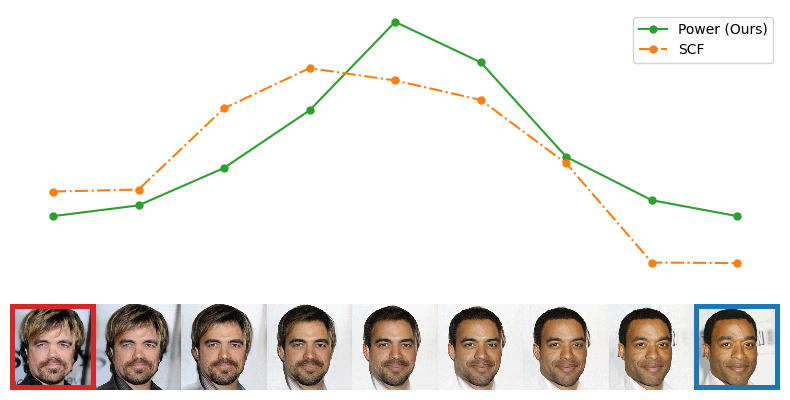

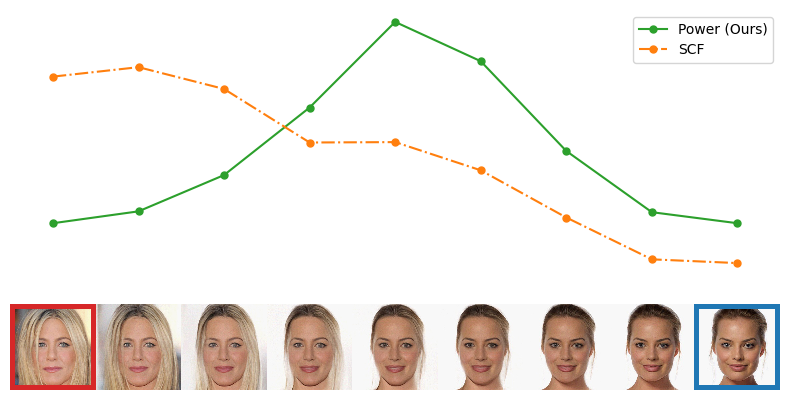

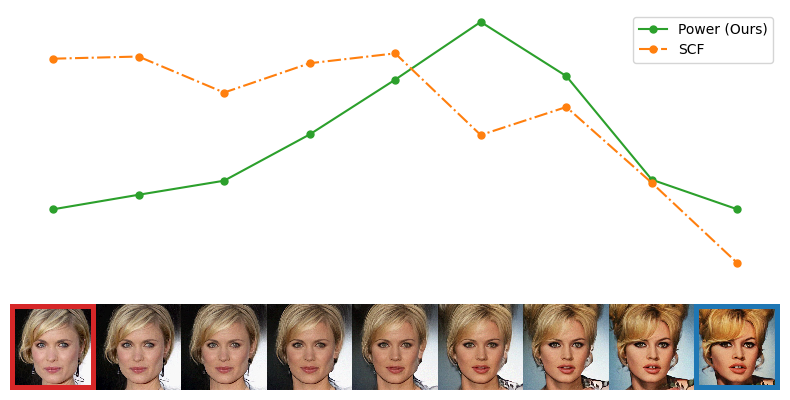

In [12]:
id_to_color = {0: "black", 1: "green", 2: "cyan"}
test_id = 0
ids = [0, 1, 2]
# import seaborn as sns

# sns.set_theme()
for test_id in ids:
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5), frameon=False)
    # Remove horizontal space between axes
    fig.subplots_adjust(hspace=0, bottom=0, wspace=0)
    first_gallery_emb = id_to_embs[test_id][0]
    second_gallery_emb = id_to_embs[test_id][-1]
    gallery_embeddings = np.concatenate(
        [first_gallery_emb[np.newaxis, :], second_gallery_emb[np.newaxis, :]]
    )
    probe_embeddings = []
    for j in np.arange(0, 9):
        probe_embeddings.append(id_to_embs[test_id][j])

    probe_embeddings = np.array(probe_embeddings)
    # compute similarity matrix
    similarity_matrix = probe_embeddings @ gallery_embeddings.T

    import torch

    probabilities = torch.exp(
        estimator.compute_all_class_log_probabilities(
            torch.tensor(similarity_matrix), T=0.5
        )
    ).numpy()
    scale = 256
    shift = 256 / 2
    axs[0].plot(
        np.arange(9) * scale + shift,
        (-np.max(probabilities, axis=1) + 1) * scale,
        marker="o",
        markersize=5,
        label=f"Power (Ours)",
        color="tab:green",  # id_to_color[test_id],
    )
    data_unc = -np.array(np.exp(id_to_unc[test_id]))
    data_unc = (data_unc - np.min(data_unc)) / (
        (np.max(data_unc) - np.min(data_unc)) * 2
    )
    axs[0].plot(
        np.arange(9) * scale + shift,
        data_unc * scale,
        marker="o",
        markersize=5,
        label=f"SCF",
        color="tab:orange",  # id_to_color[test_id],
        linestyle="dashdot",
    )
    # axs[0].set(xlabel=None)
    axs[0].axis("off")
    # ax2.imshow(np.concatenate(id_to_images[test_id], axis=1), extent=[0, -256 * 9, 0, -256], interpolation="none")
    images = []
    for j in range(9):
        image_path = str(
            loose_crop_path / (str(test_id) + "_" + str(j).zfill(4) + ".jpg")
        )
        images.append(plt.imread(image_path))
    # gallery images outline
    images[0] = draw_frame(images[0], "tab:red", 15)
    images[-1] = draw_frame(images[-1], "tab:blue", 15)
    axs[1].imshow(np.concatenate(images, axis=1), interpolation="none")
    axs[1].axis("off")
    axs[0].legend()
    fig.tight_layout()
    fig.savefig(
        f"/app/paper_assets/images/inter_{test_id}",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0,
    )

In [116]:
draw_frame(image[0], "red", 50).shape

[255   0   0]


(256, 3)

In [121]:
plt.imread(image_path).shape

(256, 256, 3)

In [34]:
probabilities

array([[0.8717897 , 0.04000503, 0.08825807],
       [0.83716476, 0.05466038, 0.10816244],
       [0.80362064, 0.06056264, 0.13581522],
       [0.6933565 , 0.09826687, 0.2083868 ],
       [0.5626637 , 0.14789468, 0.2894577 ],
       [0.4249801 , 0.24040866, 0.33459026],
       [0.21713811, 0.55414325, 0.22875638],
       [0.08047768, 0.80117196, 0.11841677],
       [0.04000503, 0.8717897 , 0.08825807]], dtype=float32)

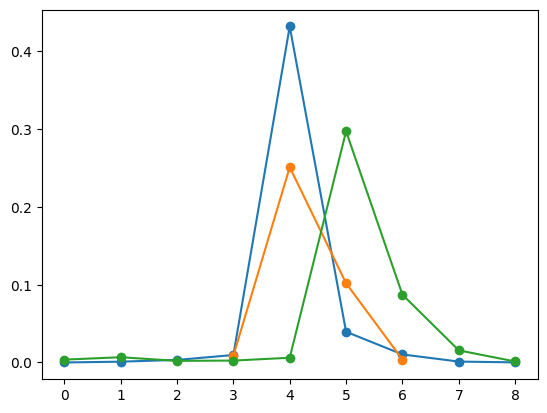

In [71]:
# compute similarity matrix
test_id = 0
for test_id in range(3):
    first_gallery_emb = id_to_embs[test_id][0]
    second_gallery_emb = id_to_embs[test_id][-1]
    gallery_embeddings = np.concatenate(
        [first_gallery_emb[np.newaxis, :], second_gallery_emb[np.newaxis, :]]
    )
    probe_embeddings = []
    for j in np.arange(0, 9):
        probe_embeddings.append(id_to_embs[test_id][j])

    probe_embeddings = np.array(probe_embeddings)
    similarity_matrix = probe_embeddings @ gallery_embeddings.T

    import torch

    probabilities = torch.exp(
        estimator.compute_all_class_log_probabilities(torch.tensor(similarity_matrix))
    ).numpy()

    plt.plot(np.arange(9), -np.max(probabilities, axis=1) + 1, marker="o")

(9, 2)

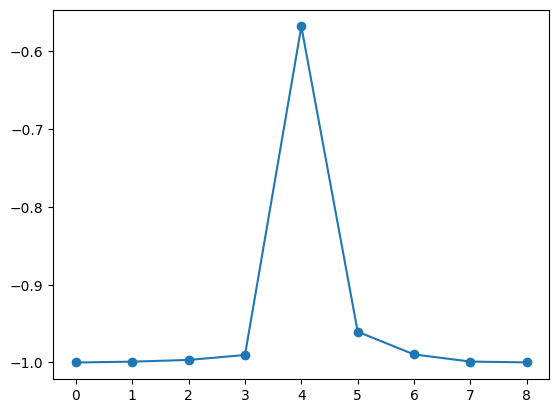